#### Thank you to Chris Waters for sharing his how-to-reproduce notebook.
Here is a demo that DM-42162 now matches ep_pipe's divisadero calc exactly

In [1]:
import lsst.eo.pipe as eoPipe  # setup -j -r /sdf/group/rubin/u/yusra/atools-camera/eo_pipe
import lsst.daf.butler as dB
import numpy as np
import matplotlib.pyplot as plt

# Divisadero needs the flat calibration to run on
butler = dB.Butler("/sdf/group/rubin/user/czw/ci_cpp_gen3-v2/DATA")

flat = butler.get("flat", instrument="LATISS", detector=0, physical_filter="RG610~empty", collections="ci_cpp_flat")

camera = butler.get("camera", instrument="LATISS", collections="LATISS/calib/unbounded")

# https://github.com/lsst-camera-dh/eo_pipe/blob/main/python/lsst/eo/pipe/divisaderoTearingTask.py#L115
divisaderoTask = eoPipe.DivisaderoTearingTask()

eoPresults = divisaderoTask.run(flat, camera)

# setup -j -r /sdf/group/rubin/u/yusra/atools-camera/ip_isr or u/yusra/DM-42162
import importlib
import lsst.ip.isr.isrStatistics 
importlib.reload(lsst.ip.isr.isrStatistics)

config = lsst.ip.isr.isrStatistics.IsrStatisticsTask.ConfigClass()
config.doDivisaderoStatistics=True
config.doProjectionStatistics=False
config.projectionMinimum = 10
config.projectionMaximum = 210

task = lsst.ip.isr.isrStatistics.IsrStatisticsTask(config=config)
results = task.run(flat, overscanResults=None, ptc=None, flat=flat)

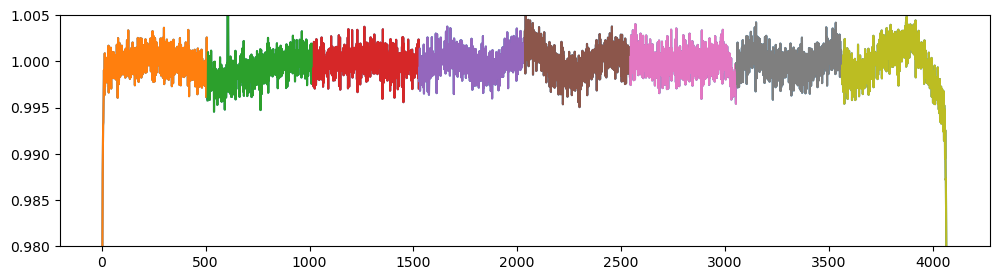

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 3))
plt.plot(eoPresults.divisadero_response.item()['RXX_S00'][0])

# DM profiles are still in amplifier coordinates
xOffset = 0
for ampName in ('C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17'):
    xSeq = np.arange(0, 509) + xOffset  # matplotlib complained that I had supplied 
                                        # a (509, ) and a (459, ) inputs.  509 was
                                        # what I expected the length to be.  This 
                                        # matches the 30*2 skips.
    # Offset the DM results
    plt.plot(xSeq, np.array(results.results['DIVISADERO'][ampName]['DIVISADERO_PROFILE']), )
    plt.ylim(0.98,1.005)
    #plt.xlim(0, 512)
    xOffset += 509  # increment xoffset to handle amp coordinates.

In [3]:
for amp, r in results.results['DIVISADERO'].items():
    print(amp, r['DIVISADERO_MAX'])

amps = [r[0] for r in  results.results['DIVISADERO'].items()]
divisadero_max = [r[1]['DIVISADERO_MAX'] for r in  results.results['DIVISADERO'].items()]

C10 0.00421059846496552
C11 0.00421059846496552
C12 0.0029365819555389194
C13 0.0033212979820353983
C14 0.0033212979820353983
C15 0.004560348942725612
C16 0.004560348942725612
C17 0.001966250753353993
C07 0.008100164501909202
C06 0.013765295941237099
C05 0.013765295941237099
C04 0.0061301534405456826
C03 0.003212800693645712
C02 0.004629904833395093
C01 0.004629904833395093
C00 0.002562041199474119


In [4]:
eoPresults.divisadero_stats

,det_name,amp_name,divisadero_tearing
0,RXX_S00,C10,0.004211
1,RXX_S00,C11,0.004211
2,RXX_S00,C12,0.002937
3,RXX_S00,C13,0.003321
4,RXX_S00,C14,0.003321
5,RXX_S00,C15,0.004560
6,RXX_S00,C16,0.004560
7,RXX_S00,C17,0.001966
8,RXX_S00,C00,0.002562
9,RXX_S00,C01,0.004630


In [6]:
import pandas as pd 
dmResults = pd.DataFrame()
dmResults["amp_name"] = amps
dmResults["ip_isr_divisadero"] = divisadero_max
pd.merge(eoPresults.divisadero_stats, dmResults, left_on="amp_name", right_on="amp_name")

,det_name,amp_name,divisadero_tearing,ip_isr_divisadero
0,RXX_S00,C10,0.004211,0.004211
1,RXX_S00,C11,0.004211,0.004211
2,RXX_S00,C12,0.002937,0.002937
3,RXX_S00,C13,0.003321,0.003321
4,RXX_S00,C14,0.003321,0.003321
5,RXX_S00,C15,0.004560,0.004560
6,RXX_S00,C16,0.004560,0.004560
7,RXX_S00,C17,0.001966,0.001966
8,RXX_S00,C00,0.002562,0.002562
9,RXX_S00,C01,0.004630,0.004630
